In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
import datetime
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt

from configs import COMPANIES_LIST, start_date, end_date
from utils import smartDataReader,get_last_raw,deal_with_add_constraints
pd.set_option("display.max_columns", 101)

In [92]:
df= smartDataReader(name=COMPANIES_LIST,data_source='yahoo',start=start_date,end=end_date,force_reload=False,retry_count=30)
df['Adj Close'].head(2)
# COMPANIES_LIST

Loading data from disk


Symbols,AAL,BP,CCL,COLM,DAL,DIS,GPS,GRA,LUV,RCL,RDS-B,RYAAY,SAVE,TOT
Date,,,,,,,,,,,,,,
2015-01-02,51.079918,27.209009,38.649097,41.776554,44.270039,87.376266,33.107903,90.740654,40.537239,73.084160,49.447544,66.555290,74.239998,38.235725
2015-01-05,51.051483,25.767183,38.462677,42.115829,43.531906,86.099403,33.321358,87.952431,39.540192,71.991646,46.872143,65.851105,74.379997,35.918873


In [93]:
tickers=df['Adj Close'].columns[~df['Adj Close'][:3].isna().any()]
tickers
df=df['Adj Close'][tickers].dropna()
df.head(2)
# df=df[columns_leave].dropna().groupby(pd.Grouper(key = None, freq = 'W')).apply(get_last_raw).dropna()


Symbols,AAL,BP,CCL,COLM,DAL,DIS,GPS,GRA,LUV,RCL,RDS-B,RYAAY,SAVE,TOT
Date,,,,,,,,,,,,,,
2015-01-02,51.079918,27.209009,38.649097,41.776554,44.270039,87.376266,33.107903,90.740654,40.537239,73.084160,49.447544,66.555290,74.239998,38.235725
2015-01-05,51.051483,25.767183,38.462677,42.115829,43.531906,86.099403,33.321358,87.952431,39.540192,71.991646,46.872143,65.851105,74.379997,35.918873


In [94]:
def calc_neg_div_ratio(weights, mean_returns, cov, rf):
    V=cov.values
    sigmas=np.sqrt(np.diag(V))
    weights=np.asarray(weights)
    negative_div_ratio=-np.dot(weights, sigmas) / np.sqrt(np.matmul(np.matmul(weights.reshape(1, -1), V), weights.reshape(-1, 1)))
    return negative_div_ratio

def calc_portfolio_perf_VaR(weights, mean_returns, cov, alpha=0.05, days=252):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_return, portfolio_std, portfolio_var

In [102]:
def calc_portfolio_perf(weights, mean_returns, cov, rf,alpha=0.05):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    negative_div_ratio= calc_neg_div_ratio(weights, mean_returns, cov, rf)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_return, portfolio_std, sharpe_ratio,negative_div_ratio,portfolio_var


def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns) + 5, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio,negative_div_ratio,VaR= calc_portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0, i] = portfolio_return
        results_matrix[1, i] = portfolio_std
        results_matrix[2, i] = sharpe_ratio
        results_matrix[3, i] = negative_div_ratio
        results_matrix[4, i] = VaR

        # iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j + 5, i] = weights[j]

    results_df = pd.DataFrame(results_matrix.T, columns=['ret', 'stdev', 'sharpe',"divcoef","VaR"] + [ticker for ticker in tickers])

    return results_df

In [109]:
mean_returns = df.pct_change().mean()
print(mean_returns.shape)
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.0
results_frame = simulate_random_portfolios(num_portfolios, mean_returns, cov, rf)


(14,)


In [110]:
# results_frame[results_frame['DAL']>0.2]

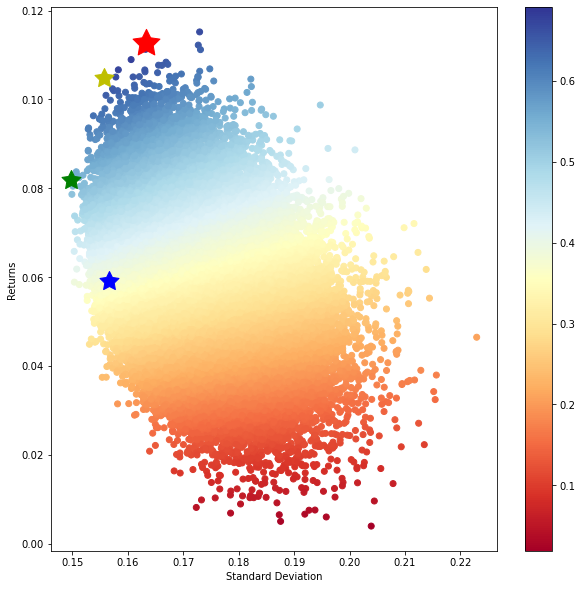

In [111]:
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]
max_div_port = results_frame.iloc[results_frame['divcoef'].idxmin()]
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]
#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(10,10))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
# plt.xlim((0.00,0.2))
# plt.ylim((0.00,0.2))
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=200)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=100)
plt.scatter(max_div_port[1],max_div_port[0],marker=(5,1,0),color='b',s=100)
plt.scatter(min_VaR_port[1],min_VaR_port[0],marker=(5,1,0),color='y',s=100)

plt.show()

In [50]:
max_sharpe_port.round(3).to_frame().T


,ret,stdev,sharpe,divcoef,AAL,BP,CCL,COLM,DAL,DIS,GPS,GRA,LUV,RCL,RDS-B,RYAAY,SAVE,TOT
17847,0.112,0.165,0.677,-1.568,0.009,0.223,0.055,0.207,0.071,0.105,0.013,0.013,0.015,0.066,0.022,0.031,0.01,0.159


In [51]:
min_vol_port.round(3).to_frame().T


,ret,stdev,sharpe,divcoef,AAL,BP,CCL,COLM,DAL,DIS,GPS,GRA,LUV,RCL,RDS-B,RYAAY,SAVE,TOT
11066,0.064,0.15,0.426,-1.673,0.005,0.082,0.102,0.027,0.008,0.122,0.034,0.182,0.1,0.032,0.061,0.11,0.012,0.122


In [52]:
max_div_port.round(3).to_frame().T

,ret,stdev,sharpe,divcoef,AAL,BP,CCL,COLM,DAL,DIS,GPS,GRA,LUV,RCL,RDS-B,RYAAY,SAVE,TOT
62788,0.065,0.155,0.418,-1.762,0.023,0.097,0.018,0.098,0.002,0.137,0.094,0.126,0.056,0.069,0.059,0.14,0.055,0.024


In [11]:
# %debug 

In [73]:
from IPython.core.debugger import set_trace

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

def max_diversification(mean_returns, cov, rf):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, rf)
    assets_names=list(mean_returns.index)
    add_constraints=deal_with_add_constraints(assets_names,specific_constraints=[["DAL",[0.3,0.6]]])
#     add_constraints=[]
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    constraints=constraints+add_constraints
    print(constraints)
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_neg_div_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
optimal_port_div = max_diversification(mean_returns, cov, rf)
pd.DataFrame([round(x,2) for x in optimal_port_div['x']],index=tickers).T

['AAL', 'BP', 'CCL', 'COLM', 'DAL', 'DIS', 'GPS', 'GRA', 'LUV', 'RCL', 'RDS-B', 'RYAAY', 'SAVE', 'TOT'] ['DAL', [0.3, 0.6]]
[{'type': 'eq', 'fun': <function max_diversification.<locals>.<lambda> at 0x0000021773EC3158>}, {'type': 'ineq', 'fun': <function __create_specific_constraint.<locals>.<lambda> at 0x0000021773EC30D0>}]


Symbols,AAL,BP,CCL,COLM,DAL,DIS,GPS,GRA,LUV,RCL,RDS-B,RYAAY,SAVE,TOT
0,0.0,0.11,0.0,0.08,0.3,0.05,0.12,0.1,0.0,0.02,0.08,0.11,0.03,0.0


In [23]:
def calc_neg_sharpe(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return -sharpe_ratio
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

def max_sharpe_ratio(mean_returns, cov, rf):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, rf)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_neg_sharpe, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
optimal_port_sharpe = max_sharpe_ratio(mean_returns, cov, rf)

In [24]:
pd.DataFrame([round(x,2) for x in optimal_port_sharpe['x']],index=tickers).T

Symbols,AAL,BP,CCL,COLM,DAL,DIS,GPS,GRA,LUV,RCL,RDS-B,RYAAY,SAVE,TOT
0,0.0,0.07,0.0,0.32,0.0,0.42,0.0,0.0,0.05,0.08,0.0,0.06,0.0,0.0


In [19]:

def simulate_random_portfolios_VaR(num_portfolios, mean_returns, cov, alpha, days):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, portfolio_VaR = calc_portfolio_perf_VaR(weights, mean_returns, cov, alpha, days)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = portfolio_VaR
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','VaR'] + [ticker for ticker in tickers])
        
    return results_df

In [21]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 10000
rf = 0.0
days = 252
alpha = 0.05
results_frame = simulate_random_portfolios_VaR(num_portfolios, mean_returns, cov, alpha, days)

In [20]:
#locate positon of portfolio with minimum VaR
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]
#create scatter plot coloured by VaR
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.VaR,results_frame.ret,c=results_frame.VaR,cmap='RdYlBu')
plt.xlabel('Value at Risk')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[2],min_VaR_port[0],marker=(5,1,0),color='r',s=500)
plt.show()
min_VaR_port

KeyError: 'VaR'

In [74]:
min_VaR_port.to_frame().round(2).T

,ret,stdev,VaR,AAL,DAL,LUV,RYAAY,SAVE
66008,0.09,0.22,0.27,0.0,0.27,0.36,0.37,0.0


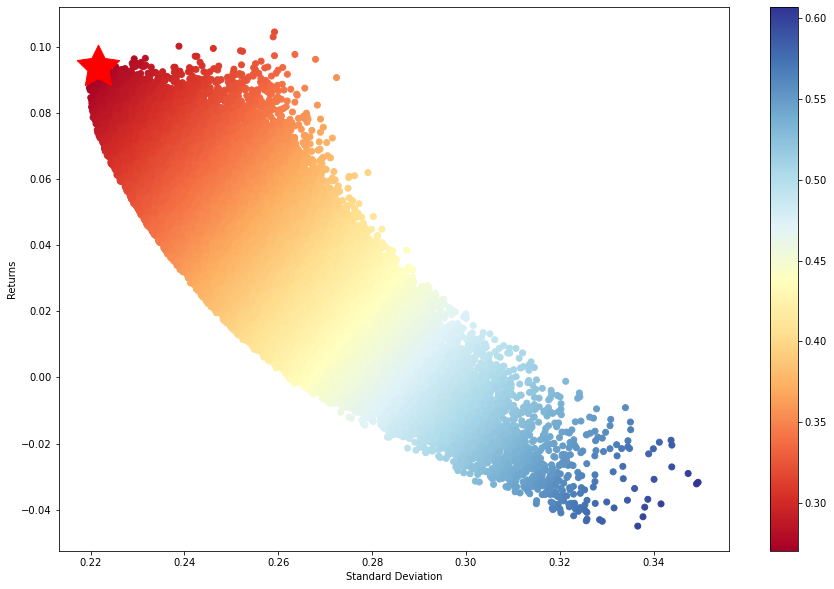

In [75]:
#locate positon of portfolio with minimum VaR
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]
#create scatter plot coloured by VaR
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.VaR,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[1],min_VaR_port[0],marker=(5,1,0),color='r',s=500)
plt.show()

In [76]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
def calc_portfolio_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var
def min_VaR(mean_returns, cov, alpha, days):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, days)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
min_port_VaR = min_VaR(mean_returns, cov, alpha, days)

In [77]:
pd.DataFrame([round(x,2) for x in min_port_VaR['x']],index=tickers).T

Symbols,AAL,DAL,LUV,RYAAY,SAVE
0,0.0,0.18,0.38,0.44,0.0
